In [25]:
import matplotlib.pyplot as plt
import tensorflow.keras
import zipfile as zf
import numpy as np
import seaborn as sns
import pandas as pd

import sys
import csv
import os
import re
import shutil
import random
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential 
from tensorflow.data import Dataset
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

## Helper Functions

The following helper functions were written by Collin Ching for his post "How to build an image classifier for waste sorting"

article : https://towardsdatascience.com/how-to-build-an-image-classifier-for-waste-sorting-6d11d3c9c478

python notebook : https://nbviewer.jupyter.org/github/collindching/Waste-Sorter/blob/master/Waste%20sorter.ipynb

In [26]:
# splits indices for a folder into train, validation, and test indices with random sampling   
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

# gets file names for a particular type of trash, given indices
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

# moves group of source files to another folder
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [27]:
def create_directory(): 
    # paths will be train/cardboard, train/glass, etc...
    subsets = ['train','valid']
    waste_types = ['cardboard','glass','metal','paper','plastic','trash']

    # create destination folders for data subset and waste type
    for subset in subsets:
        for waste_type in waste_types:
            folder = os.path.join(data_path,subset,waste_type)
            if not os.path.exists(folder):
                os.makedirs(folder)

    if not os.path.exists(os.path.join(data_path,'test')):
        os.makedirs(os.path.join(data_path,'test'))

    # move files to destination folders for each waste type
    for waste_type in waste_types:
        source_folder = os.path.join(path,waste_type)
        train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)

        # move source files to train
        train_names = get_names(waste_type,train_ind)
        train_source_files = [os.path.join(source_folder,name) for name in train_names]
        train_dest = train_path+"/"+waste_type
        move_files(train_source_files,train_dest)

        # move source files to valid
        valid_names = get_names(waste_type,valid_ind)
        valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
        valid_dest = valid_path+"/"+waste_type
        move_files(valid_source_files,valid_dest)

        # move source files to test
        test_names = get_names(waste_type,test_ind)
        test_source_files = [os.path.join(source_folder,name) for name in test_names]

        # I use data/test here because the images can be mixed up
        move_files(test_source_files,test_path)

In [28]:
def createFileList(myDir, format='.jpg'):
    fileList = []
    print(myDir)
    for root, dirs, files in os.walk(myDir, topdown=False):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
    return fileList

End of Collin's code

In [29]:
def stringContains(filePath):
    if "paper" in filePath:
        return 0
    elif "cardboard" in filePath:
        return 1
    elif "trash" in filePath:
        return 2
    elif "plastic" in filePath:
        return 3
    elif "metal" in filePath:
        return 4
    elif "glass" in filePath:
        return 5
    else:
        return 6

def convertToMatrix(fileList,num_images):
    
    num_pixels = 196608
    data = np.empty((num_images,num_pixels))
    labels = []
    label_count = [0,0,0,0,0,0,0]
    index = 0
    
    for file in fileList:
        
        img = Image.open(file) # open image
        arr = np.array(img.convert('L')) # convert to grey and place in numpy array
        vec = arr.ravel() # flatten to vector
        data[index,:] = vec.T # add to matrix
        
        name = stringContains(img.filename) # get image name
        labels = np.append(labels,name) # add to array
        label_count[name] += 1
        
        index += 1

    return data, labels, label_count

## Import Images

In [30]:
path = "dataset-resized"
data_path = "data"
test_path = "data/test"
train_path = "data/train"
valid_path = "data/valid"

In [31]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

print(files)

<zipfile.ZipFile [closed]>


In [32]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['paper', '.DS_Store', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [33]:
create_directory()

Error: Destination path 'data/train/cardboard/cardboard69.jpg' already exists

In [34]:
train_files = createFileList(train_path,format='.jpg')
test_files = createFileList(test_path,format='.jpg')
valid_files = createFileList(valid_path,format='.jpg')
fileList = createFileList(path,format='.jpg')

data/train
data/test
data/valid
dataset-resized


In [35]:
print(len(train_files), "training images")
print(len(test_files), "testing images")
print(len(valid_files), "validation images")

1262 training images
635 testing images
630 validation images


## Data Processing

Convert images to arrays

In [36]:
train,train_l,train_count = convertToMatrix(train_files,1262)
test,test_l,test_count = convertToMatrix(test_files,635)
valid,valid_l,valid_count = convertToMatrix(valid_files,630)

train = train.astype('float32')
train_l = train_l.astype('uint8')
test = test.astype('float32')
test_l = test_l.astype('uint8')
valid = valid.astype('float32')
valid_l = valid_l.astype('uint8')

print("data")
print(train.shape)
print(test.shape)
print(valid.shape)

print("")

print("labels")
print(train_l.shape)
print(test_l.shape)
print(valid_l.shape)

print("")
print("count")
print(train_count)
print(test_count)
print(valid_count)

data
(1262, 196608)
(635, 196608)
(630, 196608)

labels
(1262,)
(635,)
(630,)

count
[297, 201, 68, 241, 205, 250, 0]
[149, 101, 35, 121, 103, 126, 0]
[148, 101, 34, 120, 102, 125, 0]


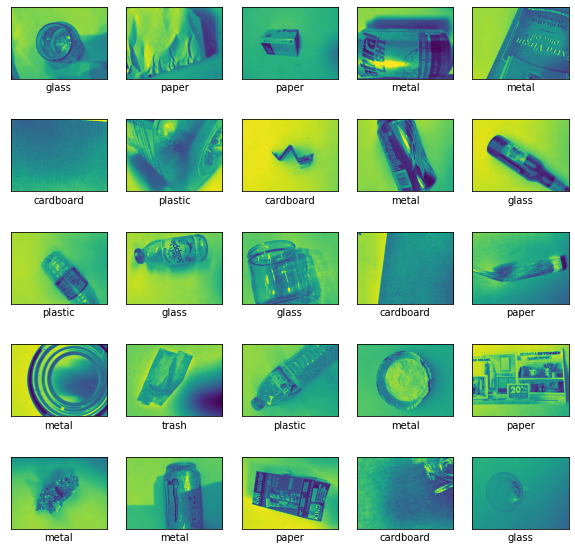

In [37]:
class_names = ['paper', 'cardboard', 'trash', 'plastic', 'metal','glass']

random_idx = []
for i in range(25):
    random.seed(i)
    random_idx.append(random.randrange(0,1262))
    
plt.figure(figsize=(10,10))
for i in range(25):
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    idx = random_idx[i]
    image = train[idx].reshape((384,512))
    plt.imshow(image)
    plt.xlabel(class_names[train_l[idx]])
    
plt.show()

Convert labels to one hot encoding

In [38]:
train_labels = to_categorical(train_l).astype('uint8')
test_labels = to_categorical(test_l).astype('uint8')
valid_labels = to_categorical(valid_l).astype('uint8')

print("Labels:")
print("train", train_l.shape)
print("test", test_l.shape)
print("validate", valid_l.shape)

print("")

print("One Hot Encoded Labels:")
print("train", train_labels.shape)
print("test", test_labels.shape)
print("validate", valid_labels.shape)

print("")

print(train_l[0])
print(train_labels[0])

Labels:
train (1262,)
test (635,)
validate (630,)

One Hot Encoded Labels:
train (1262, 6)
test (635, 6)
validate (630, 6)

0
[1 0 0 0 0 0]


Reshape data

In [39]:
rows = 384
cols = 512

## channel last configuration
train_data = train.reshape(train.shape[0],rows,cols,1)
test_data = test.reshape(test.shape[0],rows,cols,1)
valid_data = valid.reshape(valid.shape[0],rows,cols,1)

Normalise data

In [40]:
train_data /= 255.0
test_data /= 255.0
valid_data /= 255.0

print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(1262, 384, 512, 1)
(635, 384, 512, 1)
(630, 384, 512, 1)


## CNN Architecture

In [41]:
# input data
n_classes = 6
rows = 384
cols = 512
input_shape = (rows,cols,1)
class_weights = {0: 7,
                 1: 10,
                 2: 30,
                 3: 8,
                 4: 10,
                 5: 8}

# hyperparameters
batch_size = 75
epochs = 200
dropout_prob = 0.5
lr = 0.01
m = 0.0

# model architecture
opt = tensorflow.keras.optimizers.SGD(learning_rate=lr, momentum=m)
pool_size = 2
num_filters1 = 32
num_filters2 = 64
num_filters3 = 128
filter_size = 5
filter_size = 5

In [42]:
p = {'lr': (0.001,0.01,0.1),
     'batch_size': (50,75,100),
     'epochs': (50,100,200),
     'dropout': (0,0.2,1),
     'mom': (0.0,0.2,0.4)
}

In [63]:
params = {'lr': [0.001,0.01,0.1],
     'batch_size': [50,75,100],
     'epochs': [50,100,200],
     'dropout': [0,0.2],
     'mom': [0.0,0.2,0.4]
}
print(params)

{'lr': [0.001, 0.01, 0.1], 'batch_size': [50, 75, 100], 'epochs': [50, 100, 200], 'dropout': [0, 0.2], 'mom': [0.0, 0.2, 0.4]}


In [64]:
def waste_classifier_model_talos(x_train,y_train,x_val,y_val,params): 
    model = Sequential() #name="Waste Classifier Model 2")

    model.add(InputLayer(input_shape=input_shape))

    model.add(Dropout(params['dropout']))

    model.add(Conv2D(num_filters1,filter_size,activation='relu',data_format="channels_last"))#,input_shape=input_shape,))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Conv2D(num_filters2,filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))

    # the output softmax layer will have one node for each class
    model.add(Flatten())
    model.add(Dense(n_classes,activation='softmax'))
    
    opt = tensorflow.keras.optimizers.SGD(learning_rate=params['lr'], momentum=params['mom'])
    model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])

    model.summary()

    output = model.fit(x_train,y_train,batch_size=params['batch_size'],epochs=params['epochs'],class_weight=class_weights,validation_data=[x_val,y_val])

    return output, model

In [ ]:
import talos

scan_object = talos.Scan(train_data,
                         train_labels,
                         params=params,
                         model=waste_classifier_model_talos,
                         experiment_name='waste_classifier_2',
                         round_limit=10)


  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 384, 512, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 380, 508, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 190, 254, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 186, 250, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 93, 125, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 744000)            0         
_________________________________________________________________
dense (Dense)                (None, 6)                

883/883 [==============================] - 162s 184ms/sample - loss: 1.0992 - acc: 0.4451 - val_loss: 0.1337 - val_acc: 0.2982
Epoch 51/100
883/883 [==============================] - 163s 184ms/sample - loss: 1.1256 - acc: 0.4168 - val_loss: 0.1423 - val_acc: 0.1926
Epoch 52/100
883/883 [==============================] - 172s 194ms/sample - loss: 1.1230 - acc: 0.4304 - val_loss: 0.1335 - val_acc: 0.3219
Epoch 53/100
883/883 [==============================] - 169s 192ms/sample - loss: 1.0962 - acc: 0.4349 - val_loss: 0.1353 - val_acc: 0.2427
Epoch 54/100
883/883 [==============================] - 165s 187ms/sample - loss: 1.0806 - acc: 0.4485 - val_loss: 0.1346 - val_acc: 0.2982
Epoch 55/100
883/883 [==============================] - 164s 186ms/sample - loss: 1.0859 - acc: 0.4496 - val_loss: 0.1358 - val_acc: 0.2902
Epoch 56/100
883/883 [==============================] - 164s 186ms/sample - loss: 1.1114 - acc: 0.4315 - val_loss: 0.1336 - val_acc: 0.2797
Epoch 57/100
883/883 [===========


 10%|█         | 1/10 [4:43:18<42:29:49, 16998.80s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 384, 512, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 380, 508, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 190, 254, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 186, 250, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 93, 125, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 744000)            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 4

In [48]:
# accessing the results data frame
scan_object.data.head()

# accessing epoch entropy values for each round
scan_object.learning_entropy

# access the summary details
scan_object.details

experiment_name           waste_classifier
random_method             uniform_mersenne
reduction_method                      None
reduction_interval                      50
reduction_window                        20
reduction_threshold                    0.2
reduction_metric                   val_acc
complete_time               06/15/20/02:21
x_shape                (1262, 384, 512, 1)
y_shape                          (1262, 6)
dtype: object

In [49]:
# accessing the saved models
scan_object.saved_models

# accessing the saved weights for models
scan_object.saved_weights

[[array([[[[-8.03345069e-02, -2.73500737e-02,  4.62868400e-02,
             7.88249820e-02, -6.82405457e-02,  5.12296706e-02,
             8.51550549e-02,  3.93044166e-02, -1.20550841e-02,
            -3.07323746e-02, -7.08855316e-02, -4.69219275e-02,
            -4.16127481e-02,  4.37117666e-02, -3.45306434e-02,
            -5.83071262e-02,  3.27247381e-02, -7.00173229e-02,
            -2.31515919e-03,  6.89095445e-03, -6.64529353e-02,
            -5.38050607e-02,  4.86321934e-03,  3.81315425e-02,
            -6.30248562e-02,  3.21113057e-02, -3.84058580e-02,
            -5.94310500e-02,  4.72253710e-02,  8.49863887e-02,
             5.07097021e-02,  4.78639975e-02]],
  
          [[-6.65087700e-02,  5.18589020e-02,  1.08421396e-03,
             7.78803825e-02, -2.47737486e-02,  1.17733823e-02,
             7.93112516e-02, -7.86533356e-02,  3.67251560e-02,
             7.95751158e-03,  5.96396104e-02, -6.96590096e-02,
             4.15962711e-02,  7.84558058e-02, -1.11557851e-02,
    

In [50]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

In [51]:
# access the dataframe with the results
analyze_object.data

,round_epochs,loss,acc,val_loss,val_acc,batch_size,dropout,epochs,lr,mom
0,93,1.098551,0.420159,0.138331,0.298153,73,0.0,93,0.001,0.0


In [52]:
# get the number of rounds in the Scan
analyze_object.rounds()

# get the highest result for any metric
analyze_object.high('val_acc')

# get the round with the best result
analyze_object.rounds2high('val_acc')

# get the best paramaters
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])

# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['acc', 'loss', 'val_loss'])

val_loss       NaN
round_epochs   NaN
val_acc        NaN
batch_size     NaN
dropout        NaN
epochs         NaN
lr             NaN
mom            NaN
Name: val_loss, dtype: float64

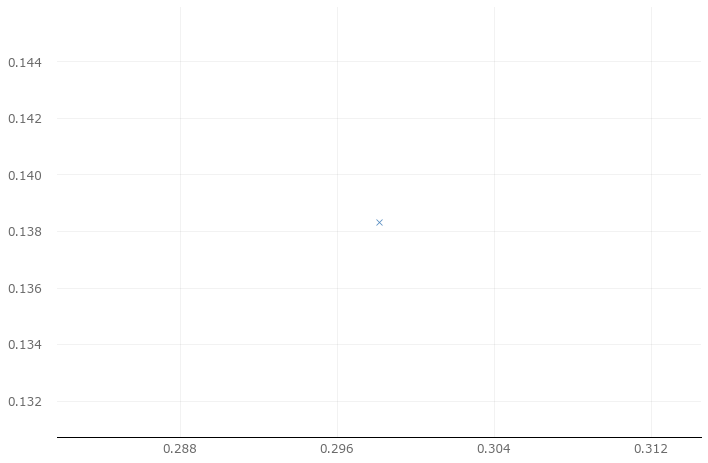

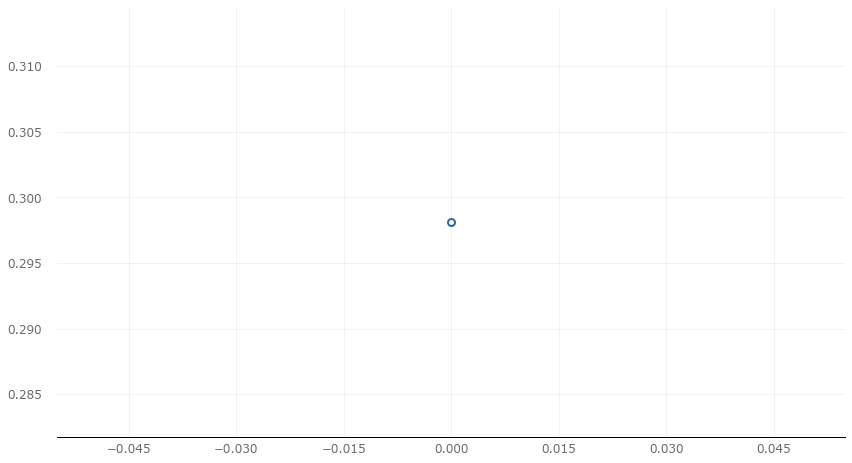

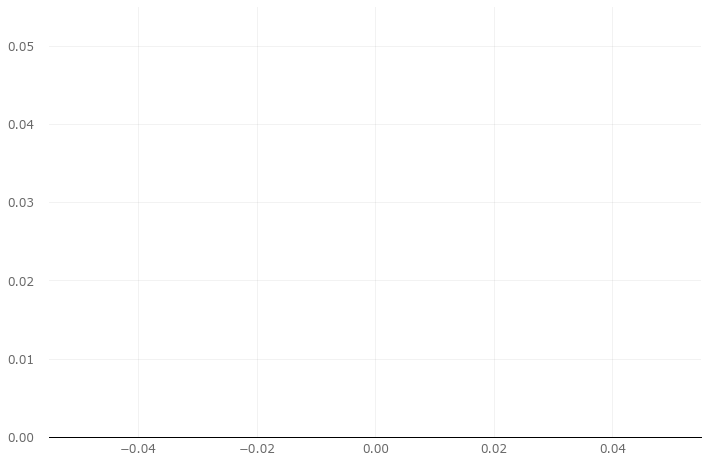

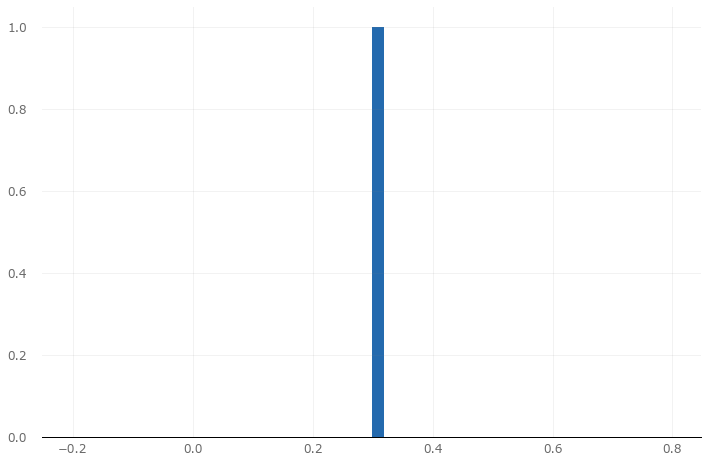

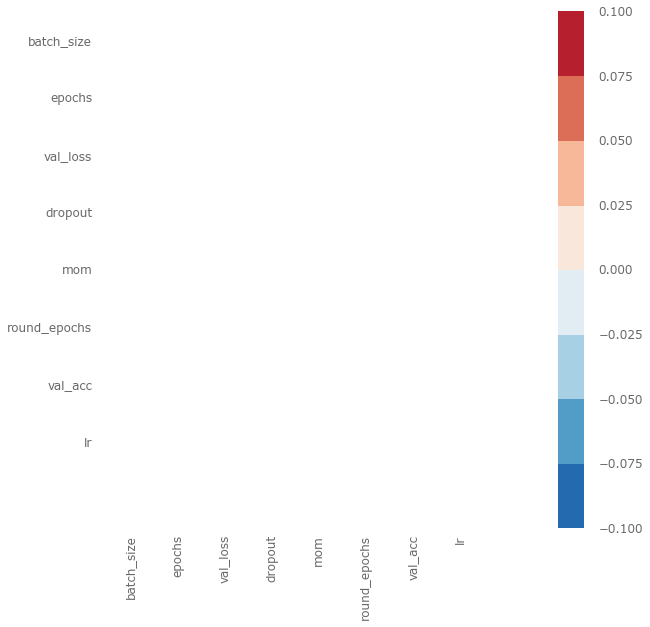

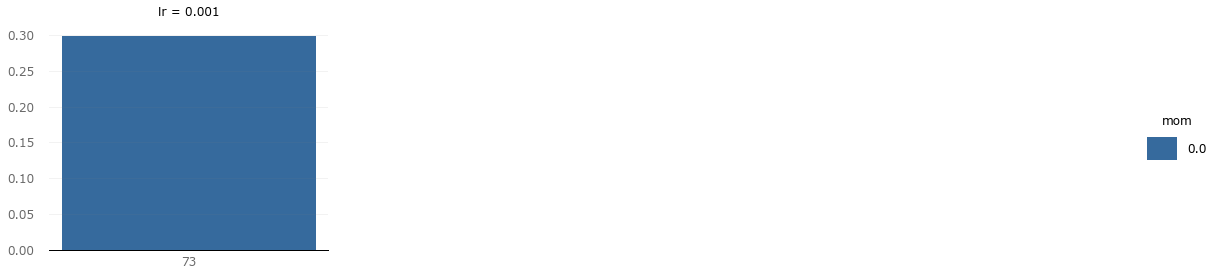

In [54]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_acc', 'val_loss')

# line plot
analyze_object.plot_line('val_acc')

# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_acc')

# a simple histogram
analyze_object.plot_hist('val_acc', bins=50)

# heatmap correlation
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

# a four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_acc', 'mom', 'lr')

In [56]:
evaluate_object = talos.Evaluate(scan_object)
evaluate_object.evaluate(train_data,train_labels, folds=10, metric='val_acc', task='multi_label')

ValueError: Unknown initializer: GlorotUniform

In [59]:
talos.Deploy(scan_object=scan_object, model_name='waste_classifier_deploy', metric='val_acc');

ValueError: Unknown initializer: GlorotUniform

In [57]:
print(p)

{'lr': (0.001, 0.01, 0.1), 'batch_size': (50, 75, 100), 'epochs': (50, 100, 200), 'dropout': (0, 0.2, 1), 'mom': (0.0, 0.2, 0.4)}


In [ ]:
def waste_classifier_model(): 
    model = Sequential()

    model.add(InputLayer(input_shape=input_shape))

    model.add(Conv2D(num_filters1,filter_size,activation='relu',data_format="channels_last"))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Conv2D(num_filters2,filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))

    # the output softmax layer will have one node for each class
    model.add(Flatten())
    model.add(Dense(n_classes,activation='softmax'))
    
    opt = tensorflow.keras.optimizers.SGD(learning_rate=lr, momentum=m)
    model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
# K.clear_session()
# waste_model = waste_classifier_model()

Convert to tensorflow dataset

In [ ]:
# train_dataset = Dataset.from_tensor_slices((train_data, train_labels))
# test_dataset = Dataset.from_tensor_slices((test_data, test_labels))
# valid_dataset = Dataset.from_tensor_slices((valid_data, valid_labels))

# train_dataset = train_dataset.batch(batch_size)
# test_dataset = test_dataset.batch(batch_size)
# valid_dataset = valid_dataset.batch(batch_size)

# print(train_dataset)


In [ ]:
# waste_model.fit(train_dataset.shuffle(3000),
#                 class_weight=class_weights,
#                 epochs=epochs,
#                 verbose=2)

In [ ]:
# test_loss, test_acc = waste_model.evaluate(test_dataset)

# print("Test accuracy:", test_acc)

In [ ]:
# print(test_dataset)
# predictions = waste_model.predict(test_dataset)

In [ ]:
# print(predictions.shape)

# print(predictions[0])

In [ ]:
# class_labels = ['paper', 'cardboard', 'trash', 'plastic', 'metal', 'glass']
# matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))

In [ ]:
# print(test_labels.shape)

In [ ]:
# print('Confusion Matrix')
# print(matrix)
# print('Classification Report')
# print(classification_report(test_labels.argmax(axis=1), predictions.argmax(axis=1), target_names=class_labels))